In [1]:
# all modules/dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [15]:
data_dir = "data_transfer"

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.Resize(size=(224,224)),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.Resize(size=(224,224)),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}




In [16]:
image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'validation']
}

In [17]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes

{'train': 814, 'validation': 256}


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [28]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6983 Acc: 0.5848
validation Loss: 0.6301 Acc: 0.6562

Epoch 1/24
----------
train Loss: 0.5907 Acc: 0.6818
validation Loss: 0.5488 Acc: 0.7383

Epoch 2/24
----------
train Loss: 0.5358 Acc: 0.7322
validation Loss: 0.4685 Acc: 0.7695

Epoch 3/24
----------
train Loss: 0.4948 Acc: 0.7580
validation Loss: 0.5044 Acc: 0.7461

Epoch 4/24
----------
train Loss: 0.5069 Acc: 0.7469
validation Loss: 0.5923 Acc: 0.6953

Epoch 5/24
----------
train Loss: 0.4786 Acc: 0.7654
validation Loss: 0.4044 Acc: 0.8203

Epoch 6/24
----------
train Loss: 0.4490 Acc: 0.7862
validation Loss: 0.4118 Acc: 0.7969

Epoch 7/24
----------
train Loss: 0.4339 Acc: 0.7912
validation Loss: 0.3936 Acc: 0.8203

Epoch 8/24
----------
train Loss: 0.4331 Acc: 0.8059
validation Loss: 0.3936 Acc: 0.8164

Epoch 9/24
----------
train Loss: 0.4385 Acc: 0.8010
validation Loss: 0.3957 Acc: 0.8086

Epoch 10/24
----------
train Loss: 0.4289 Acc: 0.8145
validation Loss: 0.3996 Acc: 0.8047

Epoch 11/

In [33]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

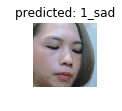

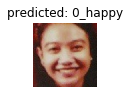

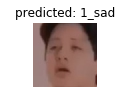

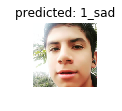

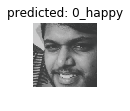

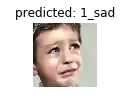

In [30]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [32]:
torch.save(model_conv.state_dict(), 'model_resnet_transfer.pt')

In [3]:
model = torch.load('model_resnet_transfer.pt')
